In [157]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm

In [158]:
sns.set()
%matplotlib inline

In [159]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
%autoreload 2

In [161]:
from sir_models.seir import SEIR, DayAheadFitter, CurveFitter
from sir_models.utils import stepwise, stepwise_soft
from sir_models.utils import eval_one_day_ahead

# Generate data

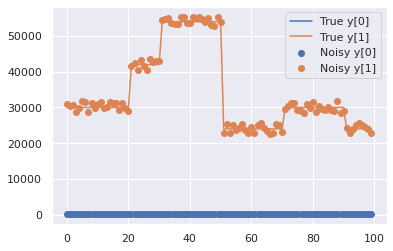

In [268]:
def target_func(t, a, b, tcs):
    for tc, c_val in tcs.items():
        if t <= tc:
            return c_val * a, (c_val * a) * b**2
        
t_vals = np.arange(0, 100)
a = 15
b = 20
tcs = {
    10: 5,
    20: 5,
    30: 7,
    50: 9,
    70: 4,
    90: 5,
    100: 4
}

y = np.array([target_func(t, a, b, tcs) for t in t_vals])
noisy_y = y+np.mean(y, axis=0)/10*(np.random.rand(*y.shape)-0.5)
plt.scatter(t_vals, noisy_y[:, 0], label='Noisy y[0]')
plt.scatter(t_vals, noisy_y[:, 1], label='Noisy y[1]')
plt.plot(t_vals, y[:, 0], label='True y[0]')
plt.plot(t_vals, y[:, 1], label='True y[1]')
plt.legend()
plt.show()

# Estimate using lmfit

In [310]:
piece_size = 5

params = lmfit.Parameters()

params.add("a", value=50, min=1, max=100, vary=True)
params.add("b", value=50, min=1, max=1000, vary=True)

for t in range(piece_size, len(t_vals), piece_size):
    params.add(f"t{t}_q", value=50, min=1, max=100, brute_step=0.1, vary=True)

In [311]:
def estimated_func(t, a, b, q_coefs):
    func1 = stepwise_soft(t, q_coefs) * params['a']
    func2 = func1 * b
    return func1, func2

In [312]:
def residual(params, t_vals, y):
    
    preds = []
    for t in t_vals:
        q_coefs = {}
        for key, value in params.items():
            if key.startswith('t'):
                coef_t = int(key.split('_')[0][1:])
                q_coefs[coef_t] = value.value

        preds.append(estimated_func(t, params['a'], params['b'], q_coefs))
    
    preds = np.array(preds)
    y = np.array(y)
    resid_0 = (preds[:, 0] - y[:, 0]) / np.maximum(preds[:, 0], y[:, 0])
    resid_1 = (preds[:, 1] - y[:, 1])  / np.maximum(preds[:, 1], y[:, 1])
    
    resid = np.concatenate([resid_0, resid_1]).flatten()
    return resid

In [313]:
def callback(params, iter, resid, *args, **kwargs):
    if iter % 10 == 0:
        print(f'Iter {iter} | MAE: {np.abs(resid).mean():0.4f}')

In [314]:
minimize_resut = lmfit.minimize(residual,
                              params,
                              args=(t_vals, noisy_y),
                              iter_cb = callback)

Iter 0 | MAE: 0.8452
Iter 10 | MAE: 0.8452
Iter 20 | MAE: 0.8452
Iter 30 | MAE: 0.7061
Iter 40 | MAE: 0.7061
Iter 50 | MAE: 0.6555
Iter 60 | MAE: 0.6555
Iter 70 | MAE: 0.5399
Iter 80 | MAE: 0.5399
Iter 90 | MAE: 0.4788
Iter 100 | MAE: 0.4788
Iter 110 | MAE: 0.4788
Iter 120 | MAE: 0.4427
Iter 130 | MAE: 0.4427
Iter 140 | MAE: 0.3918
Iter 150 | MAE: 0.3918
Iter 160 | MAE: 0.3673
Iter 170 | MAE: 0.3673
Iter 180 | MAE: 0.3243
Iter 190 | MAE: 0.3243
Iter 200 | MAE: 0.3022
Iter 210 | MAE: 0.3022
Iter 220 | MAE: 0.3022
Iter 230 | MAE: 0.2497
Iter 240 | MAE: 0.2497
Iter 250 | MAE: 0.2026
Iter 260 | MAE: 0.2026
Iter 270 | MAE: 0.1550
Iter 280 | MAE: 0.1550
Iter 290 | MAE: 0.1193
Iter 300 | MAE: 0.1193
Iter 310 | MAE: 0.1193
Iter 320 | MAE: 0.1139
Iter 330 | MAE: 0.1139
Iter 340 | MAE: 0.0600
Iter 350 | MAE: 0.0600
Iter 360 | MAE: 0.0564
Iter 370 | MAE: 0.0564
Iter 380 | MAE: 0.0564
Iter 390 | MAE: 0.0555
Iter 400 | MAE: 0.0555
Iter 410 | MAE: 0.0555
Iter 420 | MAE: 0.0555
Iter 430 | MAE: 0.0555

In [315]:
minimize_resut

In [316]:
params = minimize_resut.params

In [317]:
q_coefs = {}
for key, value in params.items():
    if key.startswith('t'):
        coef_t = int(key.split('_')[0][1:])
        q_coefs[coef_t] = value.value
        
y_pred = np.array([estimated_func(t, params['a'],  params['b'], q_coefs) for t in t_vals])

# Compare

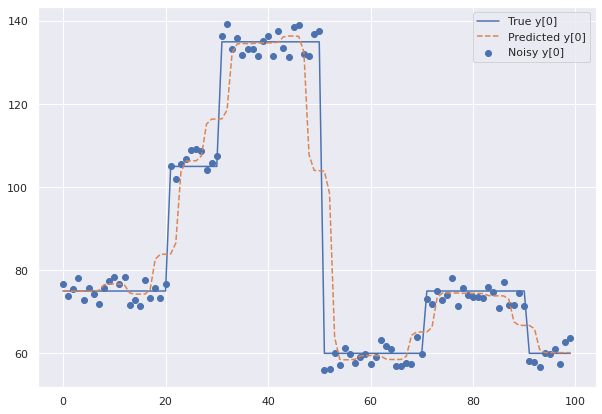

In [318]:
plt.figure(figsize=(10, 7))
plt.scatter(t_vals, noisy_y[:, 0], label='Noisy y[0]')
plt.plot(t_vals, y[:, 0], label='True y[0]')
plt.plot(t_vals, y_pred[:, 0], label='Predicted y[0]', linestyle='dashed')
plt.legend()
plt.show()

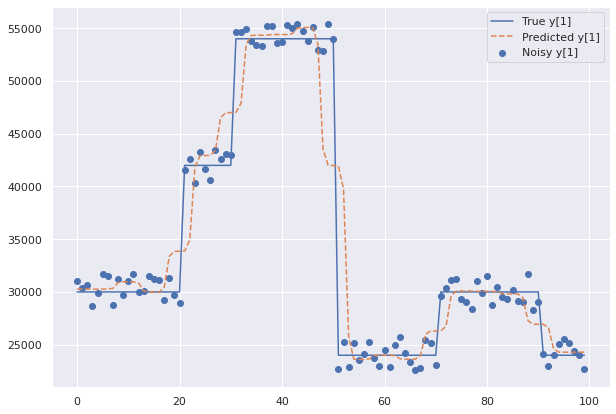

In [319]:
plt.figure(figsize=(10, 7))
plt.scatter(t_vals, noisy_y[:, 1], label='Noisy y[1]')
plt.plot(t_vals, y[:, 1], label='True y[1]')
plt.plot(t_vals, y_pred[:, 1], label='Predicted y[1]', linestyle='dashed')
plt.legend()
plt.show()